# Working with GH Data in Jupyter with Hops 🥬

### Purpose

We want to access data produced in Grasshopper in Hops and use Jupyter Notebooks as the wrapper for some analysis. There is no specific Speckle use here yet.

### Setup

The dependencies we'll need for this are `ghhops-server`, `flask`, `flask-caching`, `pandas` and `matplotlib`

This notebook assumes it is running in a venv managed with poetry, but would work equally well installing with `pip`.

In [1]:
%%capture
!poetry add ghhops-server
!poetry add flask
!poetry add flask-caching
!poetry add pandas
!poetry add matplotlib

%env FLASK_DEBUG=0

With all those installed, we'll setup the Grasshopper Hops server. In this instance we'll use Flask as a middleware to handle the endpoints.

In [2]:
# This is pretty much boilerplate for a ghhops server
from flask import Flask
import ghhops_server as hs

# Define the Flask app and host the Hops server with it.
server_app = Flask(__name__)
hops = hs.HopsFlask = hs.Hops(server_app)

# As we are not running a typical server app, we'll define the server as a process.
# More on that later
from multiprocessing import Process
server_process: Process = None

# Because the Hops server will be a long running process, we won't have access 
# to its data in the same way we might be used to within a Jupyter Notebook. 
# For this reason we'll use a Caching library that writes data to the file system.
import tempfile
from flask_caching import Cache
cache = Cache(config={'CACHE_TYPE': 'filesystem', 'CACHE_DIR': tempfile.gettempdir()})
cache.init_app(server_app)

To launch the server and have the Component available in our Grasshopper script, we set that server_process to run

```
    server_process = Process( target = server_app.run )
    server_process.start()
```
``` ini
    * Serving Flask app '__main__'
    * Running on http://127.0.0.1:5000
```

For functional reasons we'll leave that process until later.

### Define the Hops Component

This is much more interesting now. The `@hops.component` decorator allows us to define the GUI for our function. We could add an icon here which would be hosted alongside the notebook.

The `inputs` and `outputs` are both defined as an array even if there is only one parameter. Our objective for this example is to only receive data from the Grasshopper script and have it useable within the notebook.

We define an output here just for nicety here even though we are actually just passing the data through.

In [3]:
# The UI decorator
@hops.component(
  "/dataEntry", # The server endpoint
  name="Feed the Notebook", # The component name
  description="Process a Data Tree of Numbers and cache for data analysis",
  inputs=[
    #This defines the entry point as Number but able to access the tree
    hs.HopsNumber("Data", "Data", "Data to evaluate", hs.HopsParamAccess.TREE)
  ],
  outputs=[ hs.HopsNumber("Data", "Data", "Data Pass Through", hs.HopsParamAccess.TREE)]
)
def dataEntry(data: hs.HopsNumber):
  cache.set( "value_from_grasshopper", data) # This cache key is how we can get the data passed from Grasshopper in subsequent functions
  return data

If we define a simple Grasshopper script to generate a bunch of fake data. This could easily driven by some Generative or Analysis of form, an array of facade components or structural members say.

The Hops component we defined above is on the right hand side. It requires a server address (this the default for a Flask app running on a local machine) and the endpoint `/dataEntry` defined in the function decorator above.

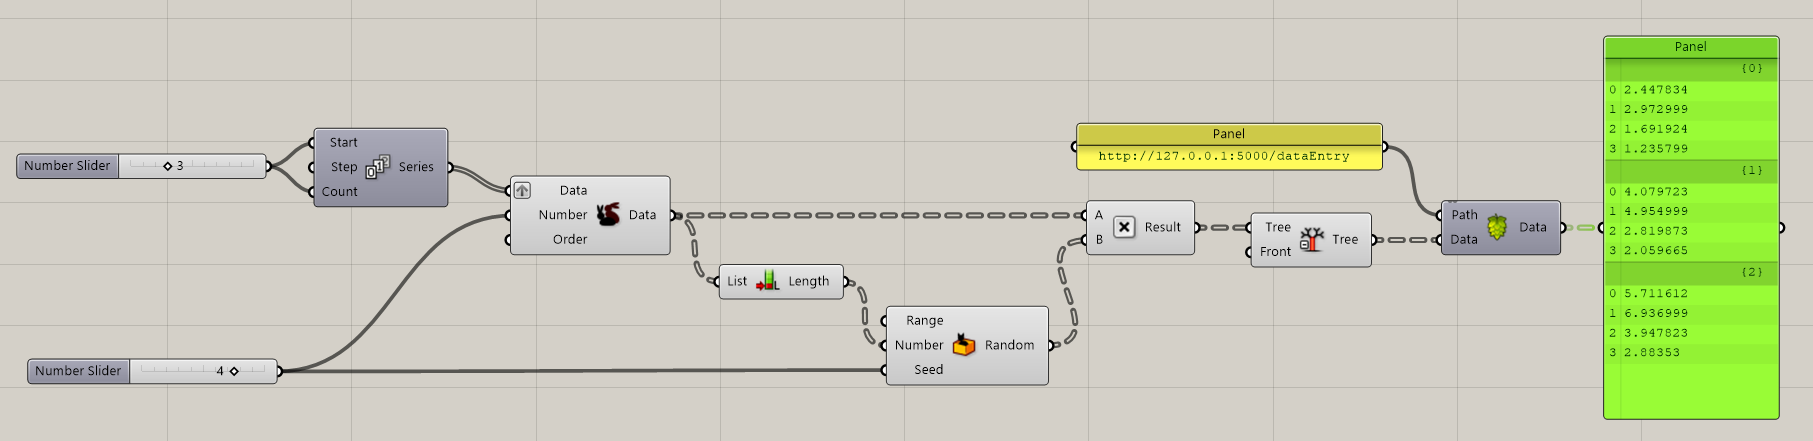

The data coming out of the component is precisely what we put in.

### Accessing the data

In order to get the data that is live in the Hops server while it is running, we access the flask cache 👇

In [49]:
data = cache.get("value_from_grasshopper")

data

{'{0}': [2.4478335801734743,
  2.972999489853624,
  1.6919239539149795,
  1.2357987413349556],
 '{1}': [4.079722633622457,
  4.95499914975604,
  2.8198732565249656,
  2.0596645688915927],
 '{2}': [5.71161168707144,
  6.936998809658457,
  3.947822559134952,
  2.8835303964482297]}

And if we want to do something with that with pandas or some visualisation...

In [50]:
import pandas

df = pandas.DataFrame(data).describe()

df

,{0},{1},{2}
count,4.000000,4.000000,4.000000
mean,2.087139,3.478565,4.869991
std,0.773698,1.289496,1.805295
min,1.235799,2.059665,2.883530
25%,1.577893,2.629821,3.681750
50%,2.069879,3.449798,4.829717
75%,2.579125,4.298542,6.017958
max,2.972999,4.954999,6.936999


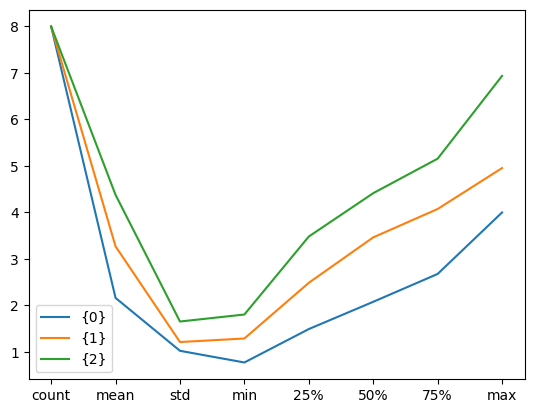

In [51]:
import matplotlib.pyplot as plt

fig1 = pandas.DataFrame(df).describe().plot();

### The actual server process

Because the server will need restarting any time the function changes, and the server is necessarily a long running process with a noisy log, we can run this at the end of the notebook before going back to play in Grasshopper or run the analysis functions above.

A simple toggle cell that when run either starts or stops the server. 

If an error is produced that an existing server is running on port 5000, we can simply restart the Jupyter kernel.

In [ ]:
server_alive = getattr(server_process, "is_alive", None)

if callable(server_alive) and server_process.is_alive() == True:
  print("stop")
  server_process.terminate()
  server_process.join()
else:
  print("start")
  server_process = Process(target=server_app.run)
  server_process.start()

start
 * Serving Flask app '__main__'
 * Debug mode: off


[INFO] WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
[INFO] Press CTRL+C to quit
[INFO] Solving using legacy API: <HopsComponent /dataEntry [Data -> Feed the Notebook -> Data] >
[INFO] 127.0.0.1 - - [06/Jan/2023 21:44:50] "POST /solve HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /dataEntry [Data -> Feed the Notebook -> Data] >
[INFO] 127.0.0.1 - - [06/Jan/2023 21:45:44] "POST /solve HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /dataEntry [Data -> Feed the Notebook -> Data] >
[INFO] 127.0.0.1 - - [06/Jan/2023 21:45:47] "POST /solve HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /dataEntry [Data -> Feed the Notebook -> Data] >
[INFO] 127.0.0.1 - - [06/Jan/2023 21:46:06] "POST /solve HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /dataEntry [Data -> Feed the Notebook -> Data] >
[INFO] 127.0.0.1 - - [06/Jan/2023